In [2]:
!pip install clip

In [3]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-oewbp80p
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-oewbp80p
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [4]:
!pip install pytorch-lightning

In [5]:
!pip install captum

In [6]:
import torch
import clip
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from captum.attr import GuidedBackprop
from torchvision.utils import make_grid

In [7]:
# Load CLIP Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# CIFAR-10 Class Labels
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

In [8]:
# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # CLIP expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Create text prompts for Zero-Shot CLIP
text_inputs = clip.tokenize([f"a photo of a {c}" for c in class_names]).to(device)

In [9]:
# Zero-Shot Classification
all_preds, all_labels = [], []

with torch.no_grad():
    text_features = model.encode_text(text_inputs)  # Encode text prompts

    for images, labels in testloader:
        images = images.to(device)
        image_features = model.encode_image(images)  # Encode images

        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Compute similarity (cosine similarity)
        similarity = (100.0 * image_features @ text_features.T)

        # Predictions: Select highest similarity
        preds = similarity.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Zero-Shot CLIP Accuracy on CIFAR-10: 84.71%

Classification Report:
               precision    recall  f1-score   support

    airplane       0.94      0.80      0.86      1000
  automobile       0.93      0.89      0.91      1000
        bird       0.76      0.82      0.79      1000
         cat       0.83      0.75      0.79      1000
        deer       0.83      0.85      0.84      1000
         dog       0.77      0.80      0.79      1000
        frog       0.89      0.74      0.81      1000
       horse       0.80      0.95      0.87      1000
        ship       0.89      0.92      0.90      1000
       truck       0.87      0.94      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



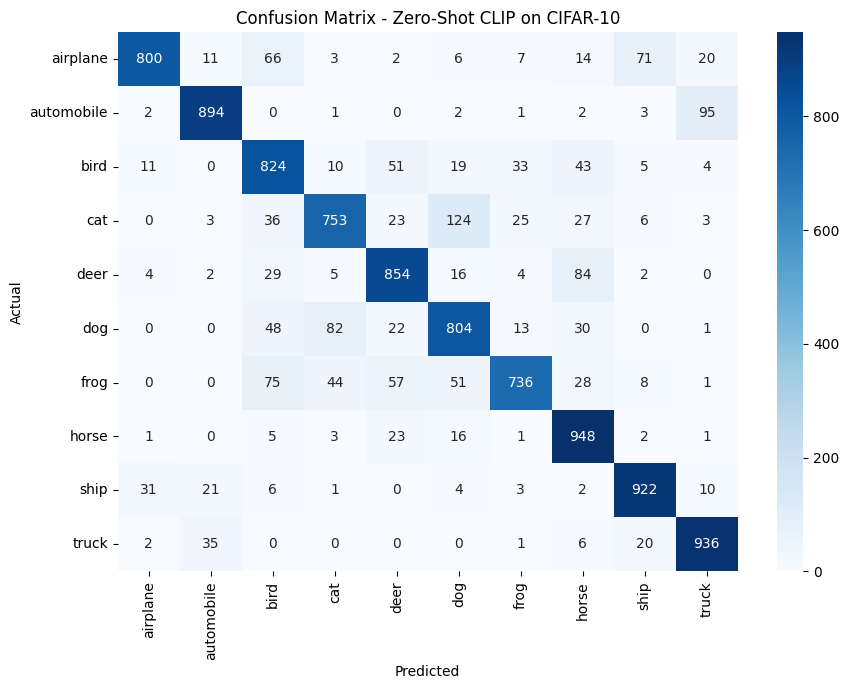

In [10]:
# Compute Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Zero-Shot CLIP Accuracy on CIFAR-10: {accuracy * 100:.2f}%")

# Classification Report
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Zero-Shot CLIP on CIFAR-10")
plt.show()


/usr/local/lib/python3.11/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


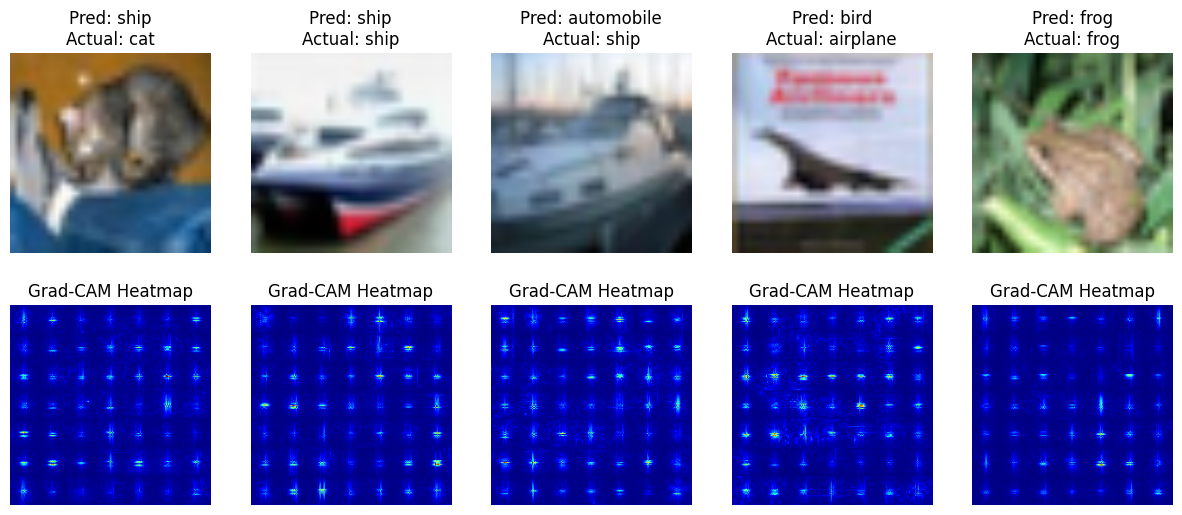

In [11]:
# XAI: Gradient-Based Explanation using GuidedBackprop
def visualize_gradcam(model, image, class_idx):
    """Visualize Grad-CAM on an image"""
    gbp = GuidedBackprop(model.visual)
    image.requires_grad_()

    # Get Grad-CAM heatmap
    # Convert class_idx to a PyTorch tensor
    guided_grads = gbp.attribute(image.unsqueeze(0).to(device), target=torch.tensor(class_idx).to(device))
    heatmap = torch.abs(guided_grads).sum(dim=1).squeeze().cpu().detach().numpy()

    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    return heatmap

# Select some images to visualize Grad-CAM
images, labels = next(iter(testloader))
images = images[:5]
labels = labels[:5]

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    img = images[i].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display

    # Get Grad-CAM heatmap
    heatmap = visualize_gradcam(model, images[i], all_preds[i])

    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Pred: {class_names[all_preds[i]]}\nActual: {class_names[labels[i]]}")

    axs[1, i].imshow(heatmap, cmap="jet")
    axs[1, i].axis('off')
    axs[1, i].set_title("Grad-CAM Heatmap")

plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


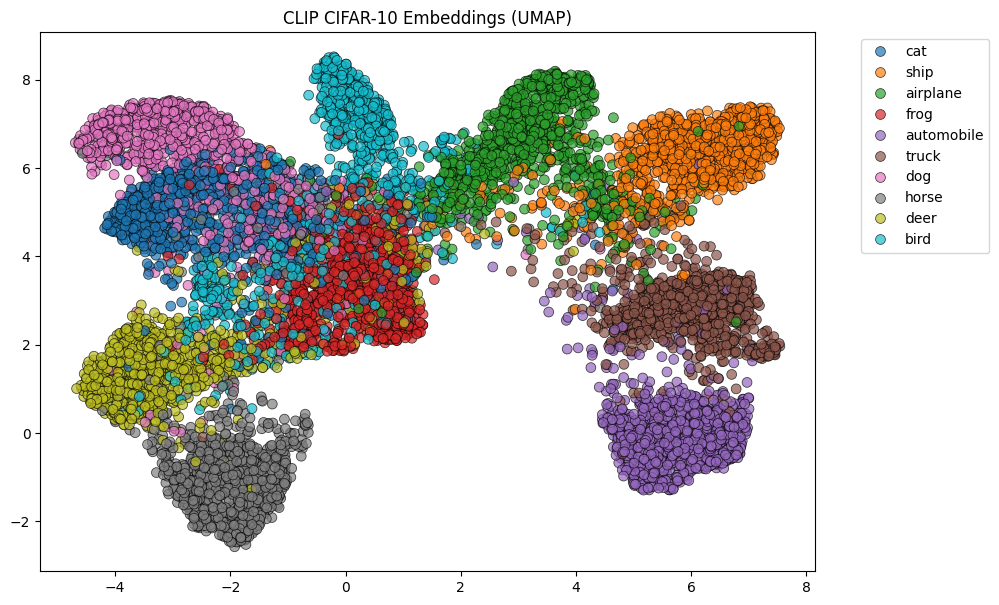

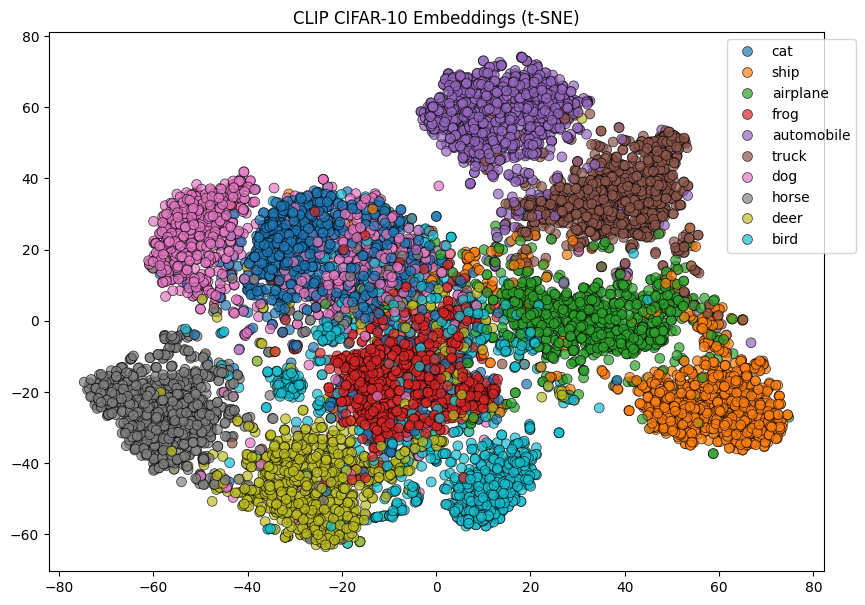

In [12]:
import umap
import seaborn as sns
from sklearn.manifold import TSNE

# Function to extract embeddings from CLIP
def get_clip_embeddings(dataloader, model):
    """Extract CLIP image embeddings for visualization"""
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = model.encode_image(images)  # Encode images
            features /= features.norm(dim=-1, keepdim=True)  # Normalize
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.numpy())

    return np.vstack(all_features), np.hstack(all_labels)

# Extract CLIP embeddings for CIFAR-10 images
image_embeddings, labels = get_clip_embeddings(testloader, model)

# Reduce dimensions using UMAP
umap_proj = umap.UMAP(n_neighbors=30, min_dist=0.3, metric="cosine").fit_transform(image_embeddings)

# Reduce dimensions using t-SNE
tsne_proj = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(image_embeddings)

# Function to plot clusters
def plot_clusters(proj, title):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=proj[:, 0], y=proj[:, 1], hue=[class_names[l] for l in labels],
        palette="tab10", alpha=0.7, edgecolor="k", s=50
    )
    plt.title(title)
    plt.legend(loc="best", bbox_to_anchor=(1.05, 1))
    plt.show()

# Plot UMAP clusters
plot_clusters(umap_proj, "CLIP CIFAR-10 Embeddings (UMAP)")

# Plot t-SNE clusters
plot_clusters(tsne_proj, "CLIP CIFAR-10 Embeddings (t-SNE)")


In [13]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00


  0%|          | 0/1000 [00:00<?, ?it/s]

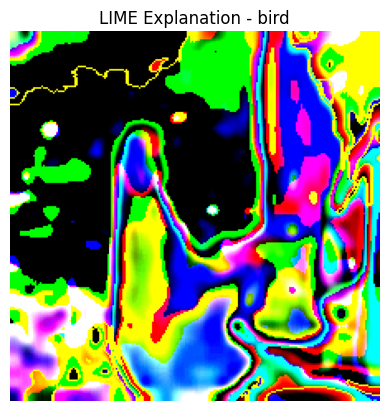

In [26]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def explain_with_lime(model, image, class_idx):
    """LIME explanation for an image using CLIP"""
    explainer = lime_image.LimeImageExplainer()

    def predict_fn(images):
        """Helper function for LIME that processes images"""
        images = [preprocess(torchvision.transforms.functional.to_pil_image(img)) for img in images]
        images = torch.stack(images).to(device)
        with torch.no_grad():
            preds = model.encode_image(images)
            preds /= preds.norm(dim=-1, keepdim=True)  # Normalize
        return preds.cpu().numpy()

    # Generate explanation
    explanation = explainer.explain_instance(
        np.array(image.permute(1, 2, 0).cpu()),
        predict_fn,
        labels=(class_idx,),
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get the mask
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
    )

    return temp, mask

# Select an image
image, label = testset[25]
from torchvision.transforms.functional import to_pil_image

image = to_pil_image(image)
image = preprocess(image).to(device)

predicted_class = all_preds[25]

# Apply LIME
lime_img, lime_mask = explain_with_lime(model, image, predicted_class)

# Plot LIME explanation
plt.imshow(mark_boundaries(lime_img, lime_mask))
plt.axis("off")
plt.title(f"LIME Explanation - {class_names[predicted_class]}")
plt.show()
